In [81]:
# Import libraries:
# data
import pandas as pd
import numpy as np
from datetime import datetime
from math import ceil

# plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# processing
from sklearn.impute import KNNImputer
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.base import clone

# clustering models
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

# metrics
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples

# multidimensional visualization methods
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

sns.set()
%matplotlib inline

In [82]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var()*(df.shape[0]-1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        #get cluster labels
        hclabels = cluster.fit_predict(df) 
        
        # concat df with labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  
        
        # compute ssw for each cluster labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  
        
        # Obtain SSB. Remember: SST = SSW + SSB
        ssb =  sst-np.sum(ssw_labels)
        
        # append the R2 of the given cluster solution
        r2.append(ssb/sst)
        
    return np.array(r2)

In [83]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

## Data Preprocessing

- Size Reduction of the Input Space;
    - Remove correlated variables
    - Remove irrelevant variables
- Normalization

In [84]:
df = pd.read_csv('cleaned_data.csv')
df.set_index('Custid', inplace = True)
df_out = pd.read_csv('outliers.csv')
df_out.set_index('Custid', inplace = True)

In [131]:
df_out.head()

,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit,YearsAsCustomer,logIncome,logLTV
Custid,,,,,,,,,,,,,,,,,,,,
4324.0,870.0,20.0,14.0,28393.0,1.0,243.0,13.0,-1.0,62.0,7.0,50.0,8.0,34.0,0.0,48.0,44.0,4.0,2.4,10.253898,0.00000
5005.0,732.0,22.0,16.0,27132.0,1.0,244.0,9.0,-2.0,81.0,11.0,18.0,14.0,25.0,32.0,30.0,64.0,5.0,2.0,10.208469,0.00000
3950.0,925.0,19.0,13.0,39572.0,1.0,420.0,11.0,-6.0,93.0,11.0,16.0,11.0,61.0,2.0,91.0,39.0,5.0,2.5,10.585877,0.00000
5642.0,584.0,19.0,13.0,29660.0,1.0,435.0,14.0,1.0,39.0,11.0,14.0,12.0,35.0,28.0,68.0,37.0,4.0,1.6,10.297555,0.00000
10969.0,1027.0,21.0,15.0,35322.0,4.0,4.0,71.0,7.0,29.0,9.0,16.0,11.0,62.0,2.0,63.0,80.0,9.0,2.8,10.472261,1.94591


### Final features for clustering:
Considering the Correlation, the PCA analysis, and the aim of this clustering task for the Security Company, which is to identify the cluster of customers so it could create marketing strategies to increase the profit, it was defined that the
the majority of our variance could be explained by these variables:
so given the PCA analysis and the correlation analysis we will try clustering with a combination of the following: 
- LTV/logLTV or income
- recency 
- per deal
- years as customer 
- education
- webvisit 

In [86]:
df.columns

Index(['Dayswus', 'Age', 'Edu', 'Income', 'Freq', 'Recency', 'Monetary', 'LTV',
       'Perdeal', 'Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert',
       'Exotic', 'WebPurchase', 'WebVisit', 'YearsAsCustomer', 'logIncome',
       'logLTV'],
      dtype='object')

In [87]:
df_behav = df[['Edu', 'Income', 'Recency','LTV','logLTV','WebVisit','Perdeal','YearsAsCustomer']].copy()
df_wine = df[['Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert',
       'Exotic']].copy()

## Clustering Processes

### Hierarchical Clustering

In [88]:
X = RobustScaler().fit_transform(df_behav[['logLTV','Recency','YearsAsCustomer','Edu','WebVisit']])

In [89]:
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=3)
hc_labels = hclust.fit_predict(X)
hc_labels

array([0, 2, 2, ..., 1, 0, 0], dtype=int64)

In [90]:
df_concat = pd.concat((df_behav, pd.Series(hc_labels, name='labels')), axis=1)
df_concat[['labels','logLTV','Recency','YearsAsCustomer','Edu','WebVisit']].groupby('labels').aggregate(["mean","std"])

logLTV               Recency            YearsAsCustomer            \
            mean       std        mean        std            mean       std   
labels                                                                        
0       2.381841  2.468596   48.700019  35.483432        2.587415  0.534027   
1       0.151845  0.388072  408.739130  82.557022        2.301186  0.521862   
2       4.901498  2.216837   56.458280  27.945724        2.283976  0.538828   

              Edu            WebVisit            
             mean       std      mean       std  
labels                                           
0       16.995448  1.856220  6.464243  1.581921  
1       16.557312  1.727944  6.462451  1.541610  
2       16.415667  1.836605  3.282470  1.954844

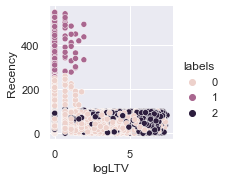

In [91]:
#plot of two of three features used
sns.pairplot(
    df_concat,
    x_vars=["logLTV"],
    y_vars=["Recency"], 
    hue="labels"
)
plt.show()

In [92]:
# Calculate R2 for a specific solution of hierarchical:
sst = get_ss(df_behav[['logLTV','Recency','YearsAsCustomer','Edu','WebVisit']])  # get total sum of squares

ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print('R² for hierarchical:', r2)

R² for hierarchical: -130122.99033122062


In [93]:
df_concat[['labels','logLTV','Recency','YearsAsCustomer','Edu','WebVisit']]

,labels,logLTV,Recency,YearsAsCustomer,Edu,WebVisit
0,0,6.098074,18.0000,1.8,20.0000,5.0000
1,2,6.289716,33.0000,2.9,18.0000,4.0000
2,2,0.000000,56.0000,1.8,12.0000,8.0000
3,0,0.000000,46.0000,2.9,16.0000,7.0000
4,0,1.386294,3.0000,2.3,16.0000,6.0000
...,...,...,...,...,...,...
9936,2,5.968708,45.0000,1.6,15.0000,2.0000
9937,2,1.609438,65.0000,1.7,12.0000,5.0000
9938,1,0.693147,368.0000,3.0,16.0000,6.0000
9939,0,5.680173,28.0000,2.7,16.0000,5.0000


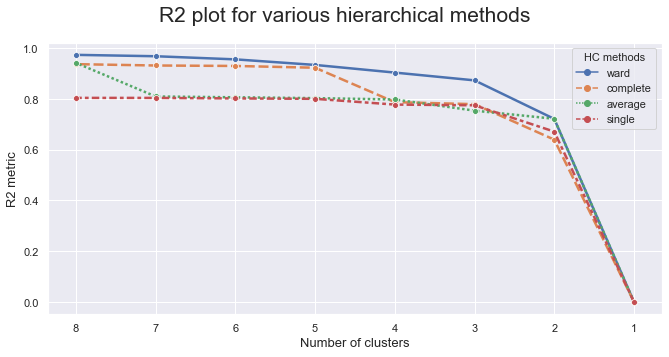

In [94]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]

# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 8
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df_behav[['logLTV','Recency','YearsAsCustomer','Edu','WebVisit']], link, max_nclus, min_nclus=1, dist="euclidean")
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [95]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = "ward"
distance = "euclidean"

# Define the clusterer
hclust = AgglomerativeClustering(distance_threshold=0,n_clusters=None, linkage=linkage, affinity=distance)
hclust.fit_predict(df_behav[['logLTV','Recency','YearsAsCustomer','Edu','WebVisit']])

array([5381, 9336, 8543, ...,    1,    2,    0], dtype=int64)

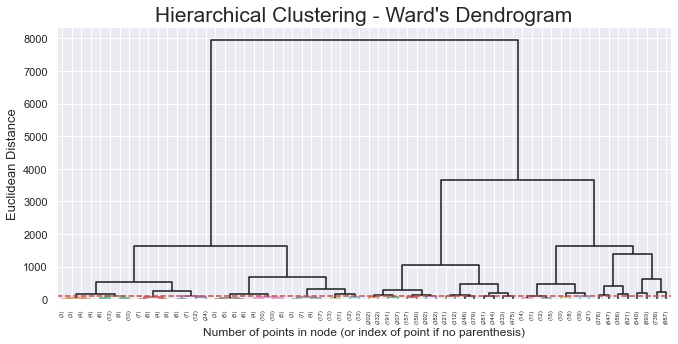

In [96]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### Kmeans to HC clustering process

In [112]:
X1 = RobustScaler().fit_transform(df_behav[['logLTV','YearsAsCustomer','Edu','WebVisit']])

In [113]:
# kmeans clustering to 90 centroids
number_clusters = 150
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=30, random_state=1)
km_labels = kmclust.fit_predict(X1)
km_labels

array([118, 114,  49, ..., 134, 105,  80])

In [114]:
#adding the labels
df_concat = pd.concat((df_behav, pd.Series(km_labels, name='labels_knn')), axis=1)
df_heir = df_concat.groupby('labels_knn').mean()
df_heir.head()

,Edu,Income,Recency,LTV,logLTV,WebVisit,Perdeal,YearsAsCustomer
labels_knn,,,,,,,,
0,17.000000,101425.973333,47.946667,472.800000,5.989133,1.333333,3.746667,1.665333
1,15.796875,57050.984375,53.828125,32.734375,3.138308,7.484375,31.328125,2.398438
2,19.259740,89552.753247,47.207792,332.883117,5.484094,3.311688,10.116883,2.158442
3,19.229167,56456.354167,51.229167,24.000000,2.888751,7.729167,38.791667,3.141667
4,19.386364,61974.659091,72.340909,14.977273,2.492935,5.681818,32.022727,1.752273


In [115]:
labels_knn=pd.Series(df_heir.index, name='labels_knn')

In [116]:
#HC with the centroids from kmeans
X2 = RobustScaler().fit_transform(df_heir[['logLTV','YearsAsCustomer','Edu','WebVisit']])

In [117]:
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=3)
hc_labels = hclust.fit_predict(X2)
hc_labels

array([0, 1, 0, 2, 2, 0, 0, 1, 1, 1, 1, 2, 1, 0, 0, 1, 2, 0, 2, 0, 0, 0,
       2, 2, 2, 0, 1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 0, 2, 2, 2, 0,
       2, 0, 2, 0, 1, 1, 1, 2, 0, 1, 0, 0, 2, 1, 0, 2, 2, 0, 0, 1, 1, 0,
       0, 2, 1, 1, 0, 2, 0, 0, 2, 1, 2, 0, 1, 2, 1, 2, 1, 0, 0, 0, 1, 1,
       1, 2, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 1, 1, 2, 0, 0, 2, 2, 2,
       2, 2, 1, 0, 2, 2, 2, 0, 0, 0, 1, 0, 1, 1, 1, 0, 2, 1, 2, 0, 0, 1,
       1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 0], dtype=int64)

In [118]:
df_concat2 = pd.concat((df_heir, labels_knn, pd.Series(hc_labels, name='labels_heir')), axis=1)
df_concat2.head()

,Edu,Income,Recency,LTV,logLTV,WebVisit,Perdeal,YearsAsCustomer,labels_knn,labels_heir
0,17.000000,101425.973333,47.946667,472.800000,5.989133,1.333333,3.746667,1.665333,0,0
1,15.796875,57050.984375,53.828125,32.734375,3.138308,7.484375,31.328125,2.398438,1,1
2,19.259740,89552.753247,47.207792,332.883117,5.484094,3.311688,10.116883,2.158442,2,0
3,19.229167,56456.354167,51.229167,24.000000,2.888751,7.729167,38.791667,3.141667,3,2
4,19.386364,61974.659091,72.340909,14.977273,2.492935,5.681818,32.022727,1.752273,4,2


In [119]:
df_concat2=df_concat2[["labels_knn","labels_heir"]]

In [120]:
df_full=pd.merge(df_concat, df_concat2, left_on="labels_knn",right_on="labels_knn")
df_full

,Edu,Income,Recency,LTV,logLTV,WebVisit,Perdeal,YearsAsCustomer,labels_knn,labels_heir
0,20.0,78473.0,18.0,445.0,6.098074,5.0,7.0,1.8,118,0
1,20.0,107978.0,95.0,474.0,6.161207,4.0,7.0,2.0,118,0
2,20.0,91650.0,12.0,89.0,4.488636,4.0,10.0,2.0,118,0
3,20.0,105078.0,33.0,241.0,5.484797,5.0,9.0,1.8,118,0
4,20.0,78582.0,95.0,76.0,4.330733,5.0,26.0,2.0,118,0
...,...,...,...,...,...,...,...,...,...,...
9936,19.0,58789.0,80.0,5.0,1.609438,5.0,28.0,1.8,4,2
9937,20.0,70471.0,43.0,8.0,2.079442,5.0,44.0,1.8,4,2
9938,19.0,78554.0,46.0,13.0,2.564949,6.0,44.0,2.0,4,2
9939,20.0,65303.0,82.0,12.0,2.484907,5.0,38.0,1.7,4,2


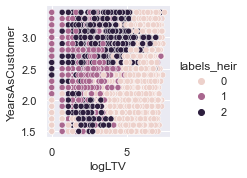

In [121]:
sns.pairplot(
    df_full,
    x_vars=["logLTV"],
    y_vars=["YearsAsCustomer"], 
    hue="labels_heir"
)
plt.show()

In [134]:
df_final = df_full[['logLTV','YearsAsCustomer','Edu','WebVisit',"labels_heir"]]
df_final.head()

,logLTV,YearsAsCustomer,Edu,WebVisit,labels_heir
0,6.098074,1.8,20.0,5.0,0
1,6.161207,2.0,20.0,4.0,0
2,4.488636,2.0,20.0,4.0,0
3,5.484797,1.8,20.0,5.0,0
4,4.330733,2.0,20.0,5.0,0


In [135]:
# Calculate R2 for a specific solution of hierarchical:
sst = get_ss(df_final[['logLTV','YearsAsCustomer','Edu','WebVisit']])  # get total sum of squares

ssw_labels = df_final.groupby(by='labels_heir').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
print('R² for hierarchical:', r2)

R² for hierarchical: 0.4713232948958384


In [159]:
df_final[['labels_heir','logLTV','YearsAsCustomer','Edu','WebVisit']].groupby('labels_heir').aggregate(["mean","std","count"])

logLTV                 YearsAsCustomer                  \
                 mean       std count            mean       std count   
labels_heir                                                             
0            5.550088  1.359787  3834        2.306938  0.548483  3834   
1            2.104589  2.384711  3028        2.453203  0.573083  3028   
2            1.733191  2.298862  3079        2.658915  0.481481  3079   

                   Edu                  WebVisit                  
                  mean       std count      mean       std count  
labels_heir                                                       
0            16.938445  1.756615  3834  2.894366  1.465867  3834  
1            15.249584  1.331234  3028  6.436333  1.502791  3028  
2            18.009419  1.349888  3079  6.886976  1.299106  3079

In [152]:
df_out.shape

(60, 21)

## Evaluation

In [155]:
#decision tree to add back in the outliers and understand the important rules in our dataset
# Preparing the data
X = df_final.drop(columns=['labels_heir'])
y = df_final.labels_heir

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 80.69% of the customers correctly


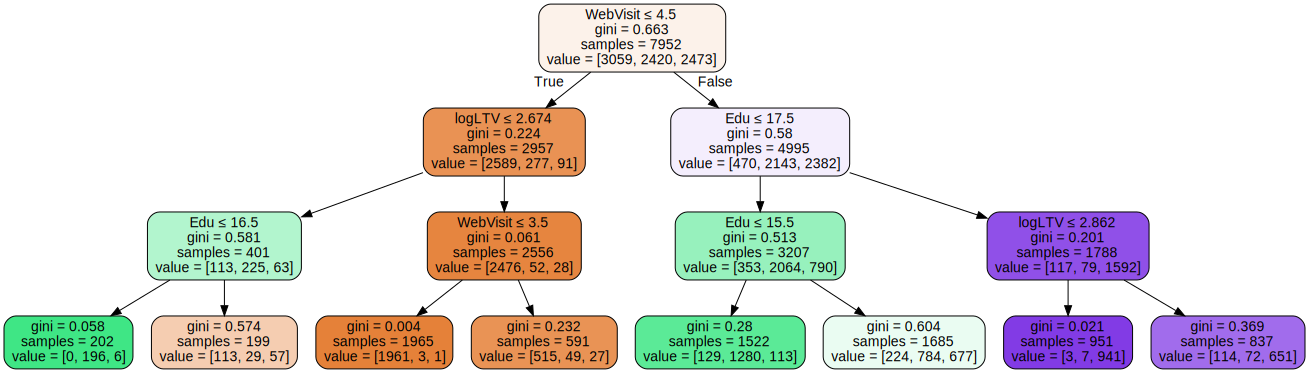

In [156]:
# Visualizing the decision tree
dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns.to_list(),
                           filled=True,
                           rounded=True,
                           special_characters=True)  
graphviz.Source(dot_data)

In [158]:
# Predicting the cluster labels of the outliers
df_out['labels_heir'] = dt.predict(df_out[['logLTV','YearsAsCustomer','Edu','WebVisit']])
df_out.head()

,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,...,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit,YearsAsCustomer,logIncome,logLTV,labels_heir
Custid,,,,,,,,,,,,,,,,,,,,,
4324.0,870.0,20.0,14.0,28393.0,1.0,243.0,13.0,-1.0,62.0,7.0,...,8.0,34.0,0.0,48.0,44.0,4.0,2.4,10.253898,0.00000,1
5005.0,732.0,22.0,16.0,27132.0,1.0,244.0,9.0,-2.0,81.0,11.0,...,14.0,25.0,32.0,30.0,64.0,5.0,2.0,10.208469,0.00000,1
3950.0,925.0,19.0,13.0,39572.0,1.0,420.0,11.0,-6.0,93.0,11.0,...,11.0,61.0,2.0,91.0,39.0,5.0,2.5,10.585877,0.00000,1
5642.0,584.0,19.0,13.0,29660.0,1.0,435.0,14.0,1.0,39.0,11.0,...,12.0,35.0,28.0,68.0,37.0,4.0,1.6,10.297555,0.00000,1
10969.0,1027.0,21.0,15.0,35322.0,4.0,4.0,71.0,7.0,29.0,9.0,...,11.0,62.0,2.0,63.0,80.0,9.0,2.8,10.472261,1.94591,1


In [173]:
#concat
df_full_merged = pd.concat([df_full.drop("labels_knn",axis=1),df_out[df_full.drop("labels_knn",axis=1).columns]], axis=0)
df_full_merged=df_full_merged.reset_index(drop=True)
#df_full_merged[['labels_heir','logLTV','YearsAsCustomer','Edu','WebVisit']].groupby('labels_heir').aggregate(["median","std","count"])

In [175]:
df_full_merged[['labels_heir','logLTV','YearsAsCustomer','Edu','WebVisit']].groupby('labels_heir').aggregate(["median","std","count"])

logLTV                 YearsAsCustomer                    Edu  \
               median       std count          median       std count median   
labels_heir                                                                    
0            5.963579  1.359686  3835             2.2  0.548530  3835   17.0   
1            0.693147  2.375529  3086             2.4  0.573156  3086   15.0   
2            0.000000  2.298701  3080             2.7  0.481446  3080   18.0   

                            WebVisit                  
                  std count   median       std count  
labels_heir                                           
0            1.757027  3835      3.0  1.465995  3835  
1            1.342307  3086      7.0  1.505955  3086  
2            1.349669  3080      7.0  1.299340  3080

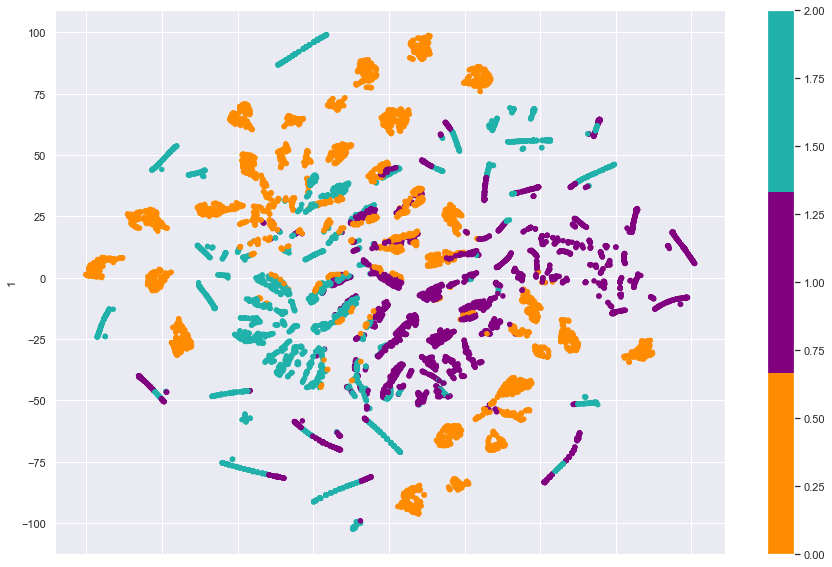

In [176]:
#TSNE Visualization
cmap = ListedColormap(["darkorange", "purple", "lightseagreen"])

two_dim = TSNE(random_state=42).fit_transform(df_full_merged[['logLTV','YearsAsCustomer','Edu','WebVisit']])
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_full_merged['labels_heir'],
                                   cmap = cmap,
                                   figsize=(15,10))
plt.show()

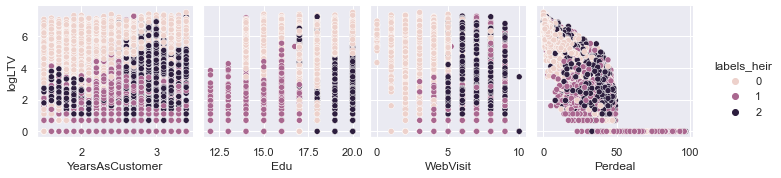

In [179]:
#graphics having added the outliers back in
sns.pairplot(
    df_full_merged,
    x_vars=['YearsAsCustomer','Edu','WebVisit','Perdeal'],
    y_vars=["logLTV"], 
    hue="labels_heir"
)
plt.show()

In [ ]:
#non_metric_features = ['EducDeg', 'GeoLivArea', 'Children', 'labels_heir', 'logMonthSal', 'logAnnualSal', 'logCustMonVal','logPremSum', 'logAnnualProfit']
#metric_features = df_full_merged.columns.drop(non_metric_features).to_list()

# All Numeric Variables' Box Plots in one figure - final clusters
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(5, ceil(df_full_merged.columns / 5), figsize=(15, 22))

# Plot data
# Iterate across axes objects and associate each box plot:
for ax, feat in zip(axes.flatten(), df_full_merged): 
    sns.boxplot(x=df_full_merged['labels_heir'], y=df_full_merged[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots - final clusters"

plt.suptitle(title, y=0.91, fontsize=15)
plt.subplots_adjust(hspace=0.25, wspace=0.25)
plt.show()